In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing
from tensorflow.keras import preprocessing , utils
from gensim.models import Word2Vec
import re

In [2]:
lines = open('data/movie_lines.txt',  encoding='utf-8', errors ='ignore').read().split('\n')
conversations_lines = open('data/movie_conversations.txt',  encoding='utf-8', errors ='ignore').read().split('\n')

In [3]:
lines[:5]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go."]

In [4]:
conversations_lines[:5]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']"]

In [5]:
# create a dictionary with key = id and value = text
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [6]:
# create a list of all conversations' lines
# lsit of lists
conversations = [ ]
for line in conversations_lines:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    conversations.append(_line.split(','))

In [7]:
conversations[:5]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208']]

In [8]:
# sort the lines into inupt texts and output texts
inputs = []
outputs = []

for conversation in conversations:
    for i in range(len(conversation)-1):
        inputs.append(id2line[conversation[i]])
        outputs.append(id2line[conversation[i+1]])

In [9]:
# load a couple of sorted input-output texts
for i in range(5):
    print(inputs[i])
    print(outputs[i]+'\n')
    

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



In [10]:
print(len(inputs))
print(len(outputs))

221616
221616


In [11]:
# change word format and remove unnecessary characters
def clean_text(text):

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

In [12]:
# clean the data
clean_inputs = []
for text in inputs:
    clean_inputs.append(clean_text(text))
    
clean_outputs = []    
for text in outputs:
    clean_outputs.append(clean_text(text))

In [13]:
# load a couple of sorted input-output texts
for i in range(5):
    print(clean_inputs[i])
    print(clean_outputs[i]+'\n')

can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again
well i thought we would start with pronunciation if that is okay with you

well i thought we would start with pronunciation if that is okay with you
not the hacking and gagging and spitting part  please

not the hacking and gagging and spitting part  please
okay then how about we try out some french cuisine  saturday  night

you are asking me out  that is so cute that is your name again
forget it

no no it is my fault  we did not have a proper introduction 
cameron



In [18]:
# remove input and output texts that are shorter than 2 words and longer than 8 words.
min_line_length = 2
max_line_length = 4

# filter out the input texts that are too short/long
short_inputs_temp = []
short_outputs_temp = []

i = 0
for text in clean_inputs:
    if len(text.split()) >= min_line_length and len(text.split()) <= max_line_length:
        short_inputs_temp.append(text)
        short_outputs_temp.append(clean_outputs[i])
    i += 1

# filter out the output texts that are too short/long
short_inputs = []
short_outputs = []

i = 0
for text in short_outputs_temp:
    if len(text.split()) >= min_line_length and len(text.split()) <= max_line_length:
        short_outputs.append(text)
        short_inputs.append(short_inputs_temp[i])
    i += 1

In [19]:
# Compare the number of lines we will use with the total number of lines.
print('# of questions:', len(short_inputs))
print('# of answers:', len(short_outputs))
print('% of data used: {}%'.format(round(len(short_inputs)/len(inputs),2)*100))

# of questions: 12682
# of answers: 12682
% of data used: 6.0%


In [20]:
# add the end of sentence token to the end of every output.
# add the go token to the beginning of every output.
for i in range(len(short_outputs)):
    short_outputs[i] = '<GO>'+short_outputs[i]+' <EOS>'

In [21]:
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(short_inputs + short_outputs)
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 7786


In [22]:
vocab = []
for word in tokenizer.word_index:
    vocab.append(word)

def tokenize(sentences):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append(tokens)
    return tokens_list, vocabulary

In [53]:
# encoder_input_data
tokenized_inputs = tokenizer.texts_to_sequences(short_inputs)
max_len_in = max([len(x) for x in tokenized_inputs])
padded_inputs = preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=max_len_in, padding='post')
encoder_input_data = np.array(padded_inputs)
print(encoder_input_data.shape, max_len_in)

(12682, 6) 6


In [54]:
# decoder_input_data
tokenized_outputs = tokenizer.texts_to_sequences(short_outputs)
max_len_out = max([len(x) for x in tokenized_outputs])
padded_outputs = preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=max_len_out, padding='post')
decoder_input_data = np.array(padded_outputs)
print(decoder_input_data.shape, max_len_out)

(12682, 9) 9


In [55]:
# decoder_output_data
tokenized_outputs = tokenizer.texts_to_sequences(short_outputs)
for i in range(len(tokenized_outputs)) :
    tokenized_outputs[i] = tokenized_outputs[i][1:-1]
padded_outputs = preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=max_len_out, padding='post')
onehot_outputs = utils.to_categorical(padded_outputs ,VOCAB_SIZE)
decoder_output_data = np.array(onehot_outputs)
print(decoder_output_data.shape)

(12682, 9, 7786)


In [56]:
encoder_inputs = tf.keras.layers.Input(shape=(max_len_in , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( max_len_out ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 6, 200)       1557200     ['input_19[0][0]']               
                                                                                                  
 embedding_3 (Embedding)        (None, 9, 200)       1557200     ['input_20[0][0]']               
                                                                                           

In [57]:
model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=256, epochs=10) 
model.save( 'model.h5' ) 

Epoch 1/10
50/50 [==============================] - 54s 874ms/step - loss: 2.8490 - accuracy: 0.3874
Epoch 2/10
50/50 [==============================] - 44s 869ms/step - loss: 2.2865 - accuracy: 0.4040
Epoch 3/10
50/50 [==============================] - 43s 867ms/step - loss: 2.1945 - accuracy: 0.4200
Epoch 4/10
50/50 [==============================] - 43s 863ms/step - loss: 2.1389 - accuracy: 0.4270
Epoch 5/10
50/50 [==============================] - 43s 862ms/step - loss: 2.0946 - accuracy: 0.4321
Epoch 6/10
50/50 [==============================] - 44s 881ms/step - loss: 2.0533 - accuracy: 0.4392
Epoch 7/10
50/50 [==============================] - 44s 871ms/step - loss: 2.0109 - accuracy: 0.4458
Epoch 8/10
50/50 [==============================] - 43s 868ms/step - loss: 1.9692 - accuracy: 0.4501
Epoch 9/10
50/50 [==============================] - 43s 862ms/step - loss: 1.9310 - accuracy: 0.4546
Epoch 10/10
50/50 [==============================] - 43s 864ms/step - loss: 1.8924 - accura

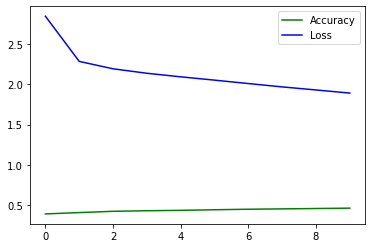

In [58]:
import matplotlib.pyplot as plt
accuracy = model.history.history['accuracy']
loss = model.history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'g')
plt.plot(epochs, loss, 'b')
plt.legend(['Accuracy','Loss'])
plt.show()

In [59]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [60]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_len_in , padding='post')

In [62]:
enc_model , dec_model = make_inference_models()

for _ in range(10):
    states_values = enc_model.predict( str_to_tokens( input( 'Enter question : ' ) ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['go']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'eos' or len(decoded_translation.split()) > max_len_out:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( decoded_translation )

Enter question : hello
 the course the minute the the the the the the
Enter question : who are you
 i am not the the the the the the the
Enter question : what is your name
 the little the the the the the the the the
Enter question : okay
 i am the the the the the the the the
Enter question : what is the the the
 the course the minute the the the the the the
Enter question : how old are you
 i am not the the the the the the the
Enter question : why are you like this
 i am not the the the the the the the


KeyboardInterrupt: ignored

In [42]:
'''because of the memory error, i trimmed the model here but the accuraccy is not good and chatbot replies only few words mostly the the the'''
'''hahah'''